In [1]:
import random
import time

import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn.functional as F

from IPython import display
from IPython.display import YouTubeVideo

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Lakota AI Code Camp Lesson 02: Introduction to Image Recognition

## History

Image recognition was at the heart of the the current neural network revolution.
There were roughly three fundamental requirements for human-level performance to occur:

1.   a large dataset;
1.   convolutional layers;
1.   computational power required for multiple layers.

The convolutional layer has its origin in the work of Dr. Kunihiko Fukushima, a Japanese scientist.
He was inspired by a paper about the vision of cats.
This led him to develop an early version of the convolutional neural network with his Neocognitron algorithm.

<img src="https://www.fi.edu/sites/default/files/2021-08/Kunihiko_Fukushima.jpg" alt="Kunihiko Fukushima" width="250" height="250">

[The Franklin Institute profile of Kunihiko Fukushima](https://www.fi.edu/en/laureates/kunihiko-fukushima)

After this, the convolutional layer was further popularized by Dr. Yann LeCun's and partner's 1989 work, called LeNet, after LeCun.
One of the primary innovations of this paper was the usage of backpropagation (more on this later in the course) to convolutional neural networks.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Yann_LeCun_-_2018_%28cropped%29.jpg/800px-Yann_LeCun_-_2018_%28cropped%29.jpg" alt="Yann Lecun" width="324" height="373">

[Conference of French computer scientist Yann LeCun, director of Facebook AI Research, at the École Polytechnique By Jérémy Barande / Ecole polytechnique Université Paris-Saclay, CC BY-SA 2.0](https://commons.wikimedia.org/w/index.php?curid=72169777)

The large dataset's inception was in 2007.
Dr. Fei-Fei Li began her work on ImageNet, a comprehensive dataset consisting of millions of images
categorized by the subject of the image.
At the time, it was the largest image dataset of its kind.

The dataset became part of the ImageNet Large Scale Visual Recognition Challenge (LSVRC), starting in 2010.
The task was:

*   given 10,000,000+ images classified into 10,000+ categories
*   classify 200,000 images into 1,000 object categories.

It is still in common usage as a neural network training dataset today.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Fei-Fei_Li_at_AI_for_Good_2017.jpg/800px-Fei-Fei_Li_at_AI_for_Good_2017.jpg" alt="Fei-Fei Li speaking at AI for Good 2017" width="227" height="338">

[By ITU Pictures - https://www.flickr.com/photos/itupictures/35011409612/, CC BY 2.0](https://commons.wikimedia.org/w/index.php?curid=69625478)

In 2012, Alex Krizhevsky, Dr. Ilya Sutskever, and Dr. Geoffrey Hinton developed **AlexNet**, a deep neural
network.
Although it only had 3 more layers than LeNet, it had roughly 3,500x more parameters (we'll talk more about this later, but it's a rough method for determining the complexity of the neural network).
LeNet had about 14,596 parameters (the actual implementation is slightly more complicated, due to weight sharing and has 9,760 parameters), whereas AlexNet had 50,844,008 parameters.
Even thought it only had 14,596 parameters, LeNet required 3 days of training.
In contrast, AlexNet took 5-6 days on a computer with 2 GPUs.

<img src="https://i.kinja-img.com/gawker-media/image/upload/c_fit,f_auto,g_center,q_60,w_1600/359da54f0801154b7db8c74420d368bf.jpg" alt="Alex Krizhevsky" width="400" height="225">

[The inside story of how AI got good enough to dominate Silicon Valley](https://qz.com/1307091/the-inside-story-of-how-ai-got-good-enough-to-dominate-silicon-valley)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Geoffrey_Hinton_at_UBC.jpg/800px-Geoffrey_Hinton_at_UBC.jpg" alt="Geoffrey Hinton" width="292" height="390">

[Geoffrey Hinton giving a lecture about deep neural networks at the University of British Columbia By Eviatar Bach - Own work, CC BY-SA 3.0](https://commons.wikimedia.org/w/index.php?curid=26477087)


We're going to go through a version of LeNet.
We're going to train a version of LeNet on an image dataset called CIFAR 10 (CIFAR stands for Canadian Institute for Advanced Research).
CIFAR 10 consists of 60,000 color images with a resolution of 32 x 32.
There are 50,000 training images and 10,000 test images.
The classes are:

1.   airplane;
1.   automobile;
1.   bird;
1.   cat;
1.   deer;
1.   dog;
1.   frog;
1.   horse;
1.   ship;
1.   truck.


We're going to instantiate a tuple of strings that represent the classes above.

In [2]:
class_list = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

We're going to instantiate an object that will allow give us an image with its label.
This first call is so that we can normalize our dataset.

In [3]:
normalize_ds = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=True,
                                            transform=torchvision.transforms.ToTensor(),
                                            )
normalize_dl = torch.utils.data.DataLoader(normalize_ds,
                                           batch_size=len(normalize_ds),
                                           shuffle=True,
                                           num_workers=0)

100%|████████████████████████████████| 170498071/170498071 [00:07<00:00, 22711975.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


We're going to normalize the data.

In [4]:
for data, _ in normalize_dl:
    mean = torch.mean(data, (0, 2, 3))
    std = torch.std(data, (0, 2, 3))

This just converts our data into a format that our model can use and normalizes it.

In [5]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=mean, std=std),
    ]
)

We actually call our dataset.

In [6]:
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

In [40]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=len(train_ds) // 8,
                                       shuffle=True, num_workers=2,
                                       pin_memory=True)
test_dl = torch.utils.data.DataLoader(train_ds, batch_size=len(test_ds),
                                      shuffle=False, num_workers=2,
                                      pin_memory=True)


We create a class for our model LeNet.

In [41]:
class LeNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3,
                                     out_channels=6,
                                     kernel_size=5,
                                     padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6,
                                     out_channels=16,
                                     kernel_size=5)
        self.pool = torch.nn.AvgPool2d(kernel_size=2,
                                       stride=2)
        self.fc1 = torch.nn.Linear(in_features=576,
                                   out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120,
                                   out_features=84)
        self.fc3 = torch.nn.Linear(in_features=84,
                                   out_features=10)
        self.activation = torch.tanh

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        return x

We instantiate it.

In [42]:
model = LeNet()

We create a helper function that will show us images from our dataset.

In [43]:
def imshow(img, label=None, class_list=class_list):
    # Pytorch has images in Channel x height x width, this converts to h x w x c
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    # undo the normalization
    img = std * img + mean
    # ensure that array is in the proper range to show the image.
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if label is not None:
        # label is assumed to be a (1, ) tensor
        label = class_list[label]
        plt.title(label)
    plt.pause(0.001)

We get an image from our training dataset.

In [44]:
images, classes = next(iter(train_dl))

This is the shape of our tensor (we'll go into this more later).

In [45]:
images.shape

torch.Size([6250, 3, 32, 32])

We call a random image and its label.

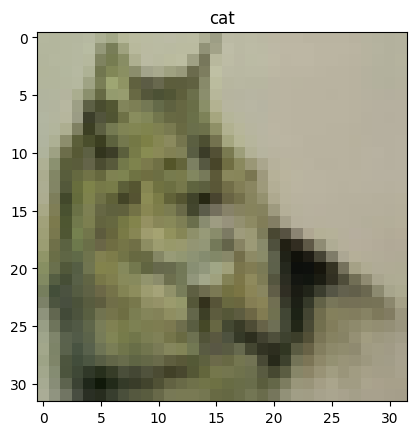

In [46]:
num = random.randint(0, len(train_ds))

image, label = train_ds[num]
imshow(image, label)

We make a helper function that takes in a model, an image, and a list of the classes and gives us a prediction.

In [47]:
def make_prediction(model, image, class_list=class_list):
    # If shape is not
    image = image.unsqueeze(0)
    pred = model(image)
    pred = torch.argmax(pred)
    return class_list[pred]

Our model isn't trained, so it should give us an incorrect prediction

In [48]:
make_prediction(model, image)

'airplane'

We make a training function.

In [49]:
def train(model, train_loader, criterion, opt, epochs=10):
    history = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    print("Epoch | Batch | Time(s) | Loss")
    print("------------------------------")

    step = 0

    for epoch in range(epochs):
        running_loss = 0.0
        t = time.time()

        for batch, (inputs, label) in enumerate(train_loader, 0):
            inputs, label = inputs.to(device), label.to(device)

            opt.zero_grad(set_to_none=True)

            outputs = model(inputs)
            loss = criterion(outputs, label)

            loss.backward()
            opt.step()

            running_loss += loss.item()
            step += 1
            history.append((step, loss))

        t = time.time() - t
        print(f"{epoch + 1:5d} | {batch + 1:5d} | {int(t):8d} | {running_loss / 8:.5f}")
        running_loss = 0

    return history

We  make an evaluation function.

In [50]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')
    return 100 * correct // total

We send our model to the GPU if its available, otherwise it goes to the CPU.

In [51]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

cuda:0


We evaluate before training.

In [52]:
evaluate(model, test_dl)

Accuracy of the network on 10000 test images: 9 %


9

We train the model.

In [53]:
history = train(model, train_dl, criterion, opt, epochs=10)

Epoch | Batch | Time(s) | Loss
------------------------------
    1 |     7 |        8 | 18.27153
    2 |     7 |        8 | 16.94027
    3 |     7 |        8 | 16.29895
    4 |     7 |        8 | 16.07398
    5 |     7 |        7 | 15.86489
    6 |     7 |        8 | 15.65028
    7 |     7 |        7 | 15.44408
    8 |     7 |        7 | 15.23885
    9 |     7 |        8 | 15.02897
   10 |     7 |        8 | 14.83649


We'll look at the plot of the loss (we'll learn more about this later) versus the number of epochs our model was trained for.

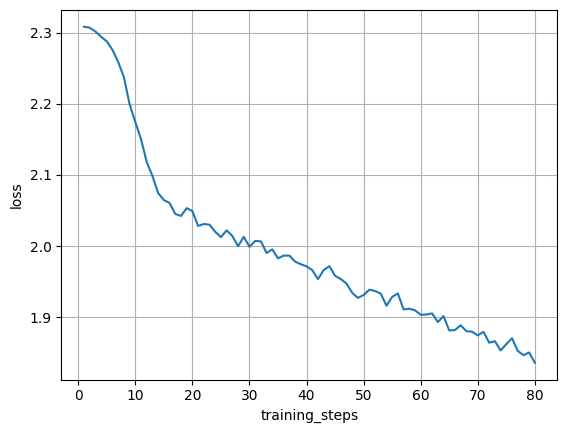

In [54]:
training_steps = np.array([step for step, _ in history])
loss = np.array([loss.item() for _, loss in history])

fig, ax = plt.subplots()
ax.plot(training_steps, loss)

ax.set(xlabel='training_steps', ylabel='loss')
ax.grid()
plt.show()

We evaluate the model.

In [56]:
evaluate(model, test_dl)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1bb99818b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1bb99818b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Accuracy of the network on 10000 test images: 37 %


37

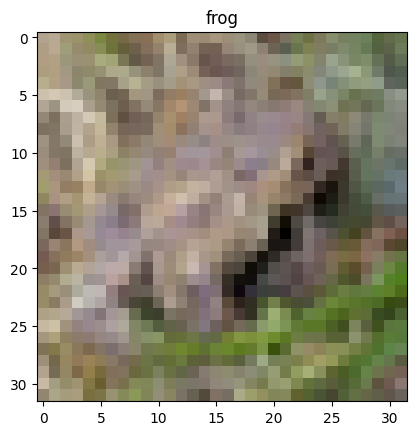

In [66]:
num = np.random.randint(0, len(train_ds))
image, label = train_ds[num]
imshow(image, label)

In [67]:
print(make_prediction(model, image.to(device)), class_list[label])

deer frog


Great! Next, we're going to go into an introduction on Object Detection.


## References

